In [36]:
%matplotlib inline

In [ ]:
from __future__ import division
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from math import sqrt
from tensorflow.contrib import learn
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib
import matplotlib.pyplot as plt

LEARNING_RATE = .001
PCA_COMPONENTS = 80
EPOCHS = 100

# color = true keeps color channels seperate
# with min_faces set to 14 - there will be 106 possible classifications

people = fetch_lfw_people(
    color=True,
    resize=0.25,
    slice_=(slice(61,189), slice(61,189)),
    min_faces_per_person=14
)

X = people.images
y = np.asarray(people.target, dtype=np.int32)

labels = people.target_names
n_classes = labels.shape[0]

In [38]:
def init_weights(shape):
    # Fix weight computation for RELU activations
    sigma = sqrt(2. / (1024 + 625))
    return tf.Variable(tf.random_normal(shape, stddev=sigma))

def model(X, w1, w2, w_fc, w_o, p_keep_conv, p_keep_hidden, act=tf.nn.relu, dropout=True):
    # First layer
    l1a = act(tf.nn.conv2d(X, w1, strides=[1, 1, 1, 1], padding='SAME'))

    l1 = tf.nn.max_pool(l1a, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    l1 = tf.nn.dropout(l1, p_keep_conv) if dropout else l1

    # Second layer
    l2a = act(tf.nn.conv2d(l1, w2, strides=[1, 1, 1, 1], padding='SAME'))
    l2 = tf.nn.max_pool(l2a, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    l2 = tf.nn.dropout(l2, p_keep_conv) if dropout else l2

    # Flattening to feed through fully-connected layer
    l2 = tf.reshape(l2, [-1, w_fc.get_shape().as_list()[0]])    # reshape to (?, 8x8x64)

    # RELU feed-forward activation layer
    l3 = act(tf.matmul(l2, w_fc))
    l3 = tf.nn.dropout(l3, p_keep_hidden) if dropout else l3

    # Classification layer
    pyx = tf.matmul(l3, w_o)

    return pyx

def one_hot(target):
    labels = np.zeros(shape=(target.shape[0], target.max() + 1))
    for i, x in enumerate(target):
        labels[i][x] = 1

    return labels

We define the model as such 

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)
y_train = one_hot(y_train)
y_test = one_hot(y_test)

tX = tf.placeholder("float", [None, 32, 32, 3])
tY = tf.placeholder("float", [None, 106])

w1 = init_weights([3, 3, 3, 32])
w2 = init_weights([3, 3, 32, 64])
w_fc = init_weights([64 * 8 * 8, 625])
w_o = init_weights([625, 106])

p_keep_conv = tf.placeholder("float")
p_keep_hidden = tf.placeholder("float")
py_x = model(tX, w1, w2, w_fc, w_o, p_keep_conv, p_keep_hidden)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=py_x, labels=tY))
train_op = tf.train.RMSPropOptimizer(LEARNING_RATE, decay=0.9).minimize(cost)
predict_op = tf.argmax(py_x, 1)

In [ ]:
import time
accuracies = []

tf.summary.histogram('conv_weights', w1)
merged = tf.summary.merge_all()

# Launch the graph in a session
with tf.Session() as sess:
    writer = tf.summary.FileWriter("./cnn/lfw-data-%s" % time.ctime(), sess.graph)

    # you need to initialize all variables
    tf.global_variables_initializer().run()
    for i in range(EPOCHS):
        training_batch = zip(range(0, len(X_train), 128),
                             range(128, len(X_train) + 1, 128))
        for start, end in training_batch:
            sess.run(train_op, feed_dict={
                tX: X_train[start:end],
                tY: y_train[start:end],
                p_keep_conv: 0.8,
                p_keep_hidden: 0.5
            })

        test_indices = np.arange(len(X_test))  # Get A Test Batch
        np.random.shuffle(test_indices)
        test_indices = test_indices[0:200]

        summary, res = sess.run([merged, predict_op], feed_dict = {
            tX: X_test[test_indices],
            p_keep_conv: 1.0,
            p_keep_hidden: 1.0
        })
        acc = np.mean(np.argmax(y_test[test_indices], axis=1) == res)
        accuracies.append(acc)
        writer.add_summary(summary, i)
        print(i, acc)

    writer.close()

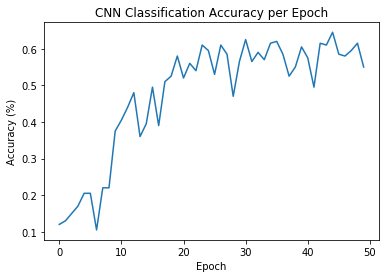

In [44]:
# Plot accuracy
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title("CNN Classification Accuracy per Epoch")
plt.show()